In [25]:
import numpy as np
from src.tests.wrapper_stack import StackWrapper
from src.var_processor.pb_threshold import signal_pre_processor

64.859375


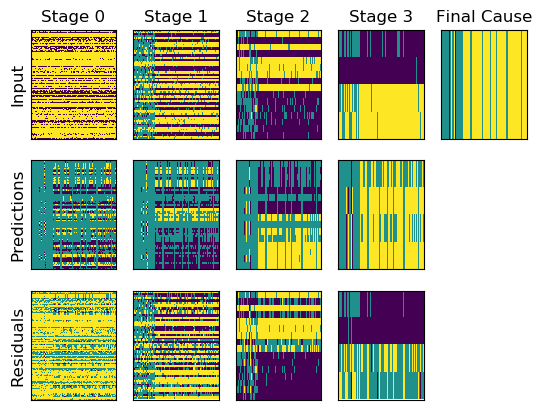

In [26]:
buf_length = 500
sen_length = 256
vec_len = 4
wrapper = StackWrapper(sen_length, vec_len, buf_length=buf_length)

# Generate fake data
data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    wrapper.iterate(input_signal)
error, mse = wrapper.error(data_in, mean)
print(mse)
wrapper.plot_buffers()

In [27]:
buf_length = 500
sen_length = 256
vec_len = 4

# Create a set of wrappers for multiple stacks
wrappers = [
    StackWrapper(sen_length, vec_len, buf_length=buf_length)
    for i in range(0, vec_len)
]

mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Generate fake data
    data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
    # Iterate over stacks
    input_signal = signal_pre_processor(data_in, mean)
    for wrapper in wrappers:
        _, _, residual = wrapper.iterate(input_signal)
        input_signal = residual

/home/ben/projects/var_processor/src/var_processor/power_iterator.py:18: RuntimeWarning: invalid value encountered in floor_divide
  scaled_array = (np.abs(array)*127//sq_root_sum)*signs


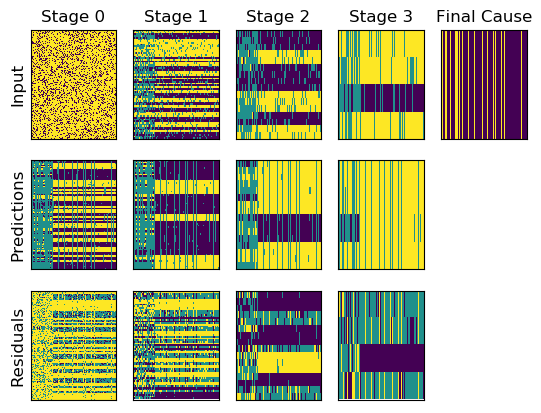

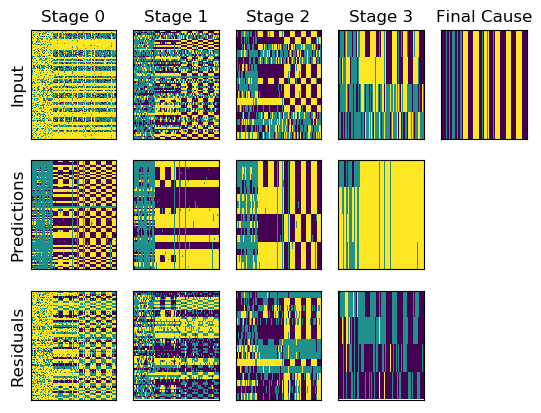

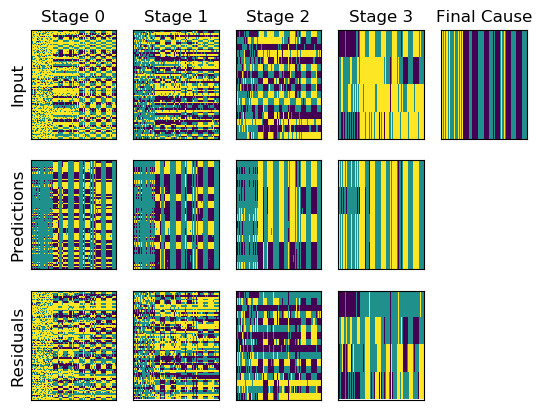

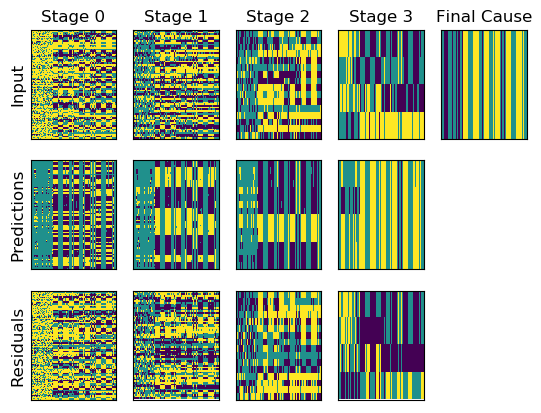

In [28]:
%matplotlib inline
for wrapper in wrappers:
    wrapper.plot_buffers()

One thing to remember in the above is that we are looking at the binary signals - if we reconstruct an original real input we may get close.

We are getting a zero eigenvector somewhere - it looks like in the fourth stage. But shouldn't our logic prevent this?

We need a way to visualise the eigenvectors...
* Each stage will have a set of eigenvectors from the VPU - we could have as a long array separated by zeros to space. Then we could plot as a bar chart.

In [29]:
for stage in wrappers[0].stack.get_eigenvectors():
    print(len(stage))

64
16
4
1


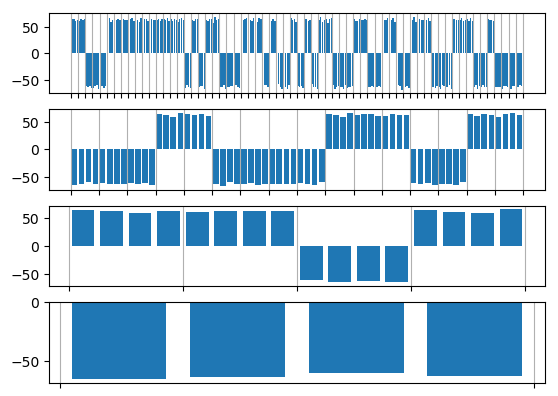

In [30]:
wrappers[0].plot_eigenvectors()

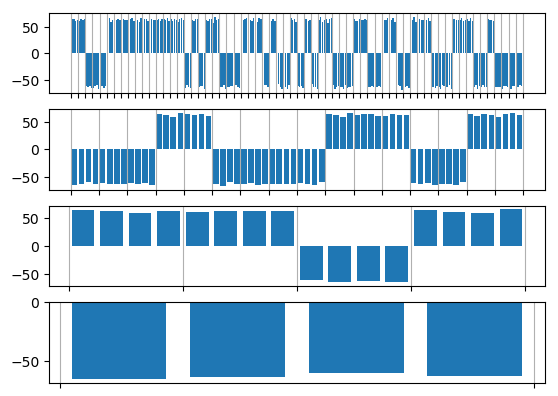

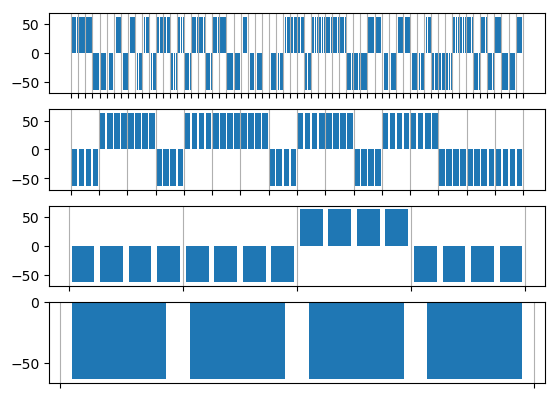

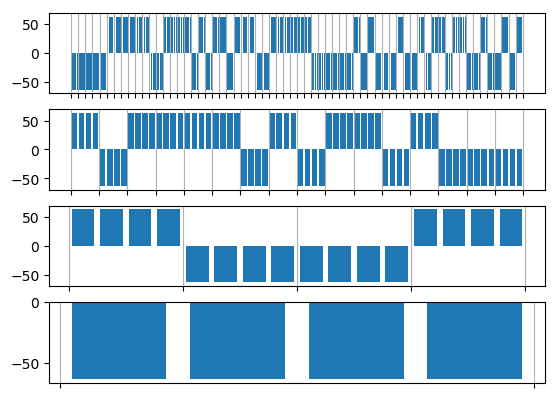

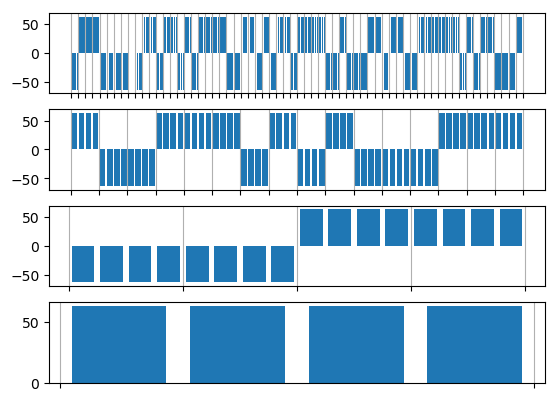

In [31]:
for wrapper in wrappers:
    wrapper.plot_eigenvectors()

# Visualising Input Reconstruction

Here's a plan:
* We need to visualise the input - as a 1D bar similar to our previous visualisations (VPU visualiser). We need this displayed in real time.
* We also need to visualise the predictions over time - it would be good to plot on the same graph as the input to compare so maybe we do make this a line graph. 
* We want to plot the different sums of predictions across different stacks - we should be more accurate as the stacks increase.
* We might also want some comparison over time - the input, reconstructions and errors as 2D plots.

See 

https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
https://python-graph-gallery.com/122-multiple-lines-chart/

We also need to sort the mean - this maybe done on the sensor side.

In [10]:
from src.var_processor.sensor import Sensor
from src.sources.fft import FFTSource

Start by creating an audio FFT sensor source.

See here for additional materials - http://localhost:8888/notebooks/2020-03-22%20-%20Visualising%20Causes.ipynb.

In [17]:
audio = FFTSource(res_factor=2)
sensor = Sensor(audio, 4)

In [18]:
sensor.get_data_length()

256

In [19]:
_, initial_frame = sensor.source.read()

In [20]:
initial_frame.shape

(274,)

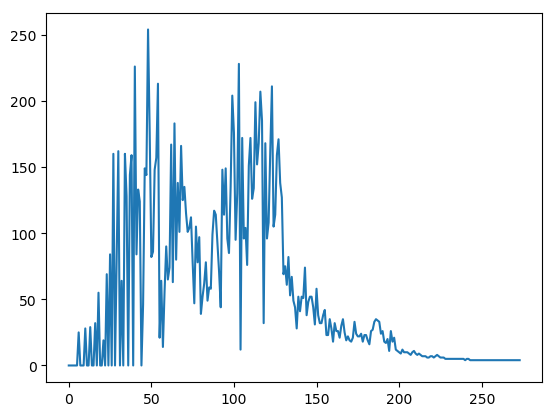

In [21]:
plt.plot(initial_frame)

In [22]:
for _ in range(0, 500):
    frame = sensor.get_frame()

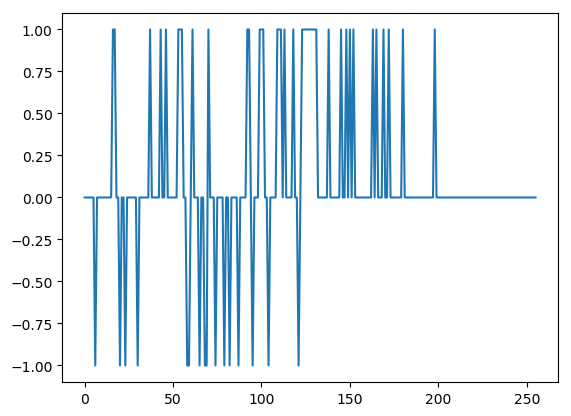

In [23]:
plt.plot(frame)

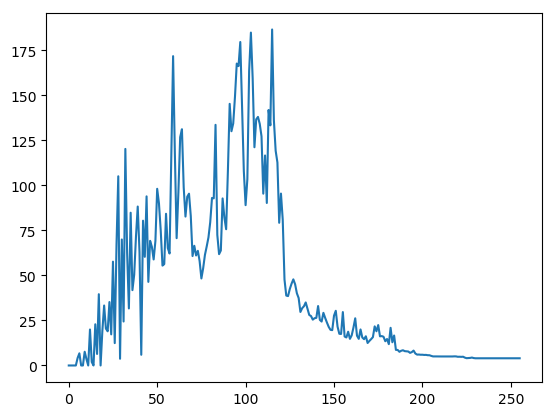

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ben/projects/var_processor/src/sources/capture.py", line 127, in update
    self.length, data = self.inp.read()
alsaaudio.ALSAAudioError: Streams pipe error [default]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ben/projects/var_processor/src/sources/capture.py", line 127, in update
    self.length, data = self.inp.read()
alsaaudio.ALSAAudioError: Streams pipe erro

In [24]:
plt.plot(sensor.mean)

So when visualising, we can have:
* input data;
* mean;
* reconstructions.

Let'f first convert our stack wrapper into a sheet class that implements a plurality of stacks.

We could generate an abstract class that has the shared interfaces, then keep expanding this.

## Class Recap

We have the following data structures:
* Covariance
* Power Iterator
* VPU
* Stage
* Stack
* Sheet
* Sensor

In [ ]:
class Sheet

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


class SheetVisualizer:
    """Object to visualise a set of stacks."""

    def __init__(self, stack_wrappers, input_generator):
        """Initialise.

        Args:
            stack_wrappers: a set of stack wrappers.
            input_generator: generator object that outputs an input for
                each iteration.
        """
        self.wrappers = stack_wrappers
        self.input_gen = input_generator
        # Get initial input size
        sen_length = self.wrappers[0].sen_length
        # Initialise single subplot
        self.figure, self.ax = plt.subplots()
        # Initialising animation
        self.animation = FuncAnimation(
            self.figure, self.update, save_count=200)
        # Initialise X Axis
        self.x_range = np.arange(0, sen_length)

        # Bed in stack
        for i in range(0, 128):
            input_data = next(self.input_gen)
            self.VPU.update_cov(input_data)

    def update(self, frame):
        """Update the visualisations."""
        # Get input data
        # print("updating")
        input_data = next(self.input_gen)
        r, residual = self.VPU.iterate(input_data)
        self.input_plot.remove()
        self.input_plot = self.axes[0].bar(
            self.x_range,
            input_data.reshape(self.size,),
            color='y')
        self.residual_plot.remove()
        self.residual_plot = self.axes[1].bar(
            self.x_range,
            residual.reshape(self.size,),
            color='r')
        self.r_plot.remove()
        self.r_plot = self.axes[2].bar(
            self.binary_range,
            r.reshape(1,),
            color='k'
        )
        self.ev_plot.remove()
        self.ev_plot = self.axes[3].bar(
            self.x_range,
            self.VPU.pi.eigenvector.reshape(self.size,),
            color='b'
        )
        time.sleep(0.25)
        return self.figure

    def show(self):
        """Show the visualisations."""
        plt.show()
